### Câu hỏi 5: Với các yếu tố thời tiết cho trước, lượng mưa dự kiến là bao nhiêu?

### 1. Import thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report

### 2. Tạo đặc trưng mới

In [2]:
def feature_engineer(data):
    df = data.copy()
    
    df['datetime'] = pd.to_datetime(df['datetime'])
    # sort data theo vị trí và thời gian
    df = df.sort_values(by=['datetime', 'location_id'])
            
    # mã hoá 'season' và 'day_night' (biến categorical)
    label_encoders = {}
    cat_cols = ['season', 'day_night']
    for col in cat_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le 

    # tạo đặc trưng rain_lag_1h (mưa 1 giờ trước)
    df['rain_lag_1h'] = df.groupby('location_id')['precipitation (mm)'].shift(1)
    
    # tạo đặc trưng pressure_diff (áp suất thay đổi)
    df['pressure_diff'] = df['pressure (hPa)'] - df.groupby('location_id')['pressure (hPa)'].shift(1)
    
    # tạo đặc trưng wind_diff (gió thay đổi)
    df['wind_diff'] = df['windspeed (km/h)'] - df.groupby('location_id')['windspeed (km/h)'].shift(1)

    # tạo đặc trưng dewpoint_dep (điểm sương phụ thuộc nhiệt độ) --> độ bão hoà hơi nước
    df['dewpoint_dep'] = df['temperature (C degree)'] - df['dewpoint (C degree)' ] 

    # xoá các dòng NaN sau khi shift dữ liệu tạo đặc trưng
    df = df.dropna()
    
    return df, 'precipitation (mm)'

### 3. Tách tập dữ liệu train-test

In [3]:
df = pd.read_csv('data/processed/weather_processed.csv')
df, target = feature_engineer(df)
input_features = [ 
    'temperature (C degree)', 'humidity (%)', 'pressure (hPa)', 
    'windspeed (km/h)', 'winddirection (degrees)', 
    'month', 'hour', 'season', 'day_night',
    'rain_lag_1h', 'pressure_diff', 'wind_diff', 'dewpoint_dep'
]

In [4]:
SPLIT_DAY = 23  
GAP = 1        

df['day_of_month'] = df['datetime'].dt.day
train = df[df['day_of_month'] <= SPLIT_DAY]
test = df[df['day_of_month'] > (SPLIT_DAY + GAP)]

X_train, y_train = train[input_features], train[target]
X_test, y_test = test[input_features], test[target]

print("Train data size: ", len(X_train))
print("Test data size: ", len(X_test))

Train data size:  225239
Test data size:  62482


### 4. Huấn luyện mô hình

#### 4.1. Mô hình phân loại: xác định có mưa hay không mưa

In [5]:
y_train_rain = (y_train > 0.1).astype(int) # ép kiểu int cho biến lượng mưa
y_test_rain = (y_test > 0.1).astype(int)

clf = HistGradientBoostingClassifier(
    learning_rate=0.05, max_iter=300, max_leaf_nodes=31,
    random_state=42, class_weight='balanced',
    categorical_features=[7, 8]
)
clf.fit(X_train, y_train_rain)

HistGradientBoostingClassifier(categorical_features=[7, 8],
                               class_weight='balanced', learning_rate=0.05,
                               max_iter=300, random_state=42)

#### 4.2. Mô hình hồi quy: dự đoán lượng mưa

In [6]:
mask_rain_train = y_train > 0.1 # lấy những dòng có mưa
X_train_rain = X_train[mask_rain_train]
y_train_rain = y_train[mask_rain_train]

reg = HistGradientBoostingRegressor(
    loss='poisson', # hàm mất mát Poisson 
    learning_rate=0.02, max_iter=500, max_leaf_nodes=31,
    random_state=42,
    categorical_features=[7, 8]
)
reg.fit(X_train_rain, y_train_rain)

HistGradientBoostingRegressor(categorical_features=[7, 8], learning_rate=0.02,
                              loss='poisson', max_iter=500, random_state=42)

### 5. Đánh giá kết quả huấn luyện

In [7]:
# xác xuất mưa từ mô hình classification
prob_rain = clf.predict_proba(X_test)[:, 1]

# dự đoán mưa cho tập test bằng mô hình regression
pred_reg = reg.predict(X_test)

# xác suất mưa <0.5 thì xem là không mưa, ngược lại lấy giá trị dự báo lượng mưa từ mô hình regression
prediction = np.where(prob_rain < 0.5, 0, pred_reg)

In [8]:
# tính r2 và MAE
r2 = r2_score(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print("R2 Score: ", r2)
print("MAE: ", mae)
print("RMSE: ", rmse, "\n")

y_pred_bin = (prediction > 0.1).astype(int)
print(classification_report(y_test_rain, y_pred_bin, target_names=['Không mưa', 'Có mưa']))

R2 Score:  0.6057460841886206
MAE:  0.2833912967041637
RMSE:  0.9203776417559039 

              precision    recall  f1-score   support

   Không mưa       0.95      0.88      0.92     45234
      Có mưa       0.74      0.88      0.80     17248

    accuracy                           0.88     62482
   macro avg       0.85      0.88      0.86     62482
weighted avg       0.89      0.88      0.88     62482



Mô hình đạt hiệu năng tốt trên cả hai bài toán hồi quy và phân loại. Với R² ≈ 0.61 và MAE thấp, mô hình dự đoán lượng mưa ở mức chấp nhận được, đặc biệt hiệu quả trong các trường hợp mưa nhỏ. Trong bài toán phân loại, mô hình đạt độ chính xác 88% và khả năng phát hiện mưa cao (recall = 0.88), phù hợp cho các hệ thống cảnh báo sớm, dù vẫn còn một số cảnh báo mưa giả.

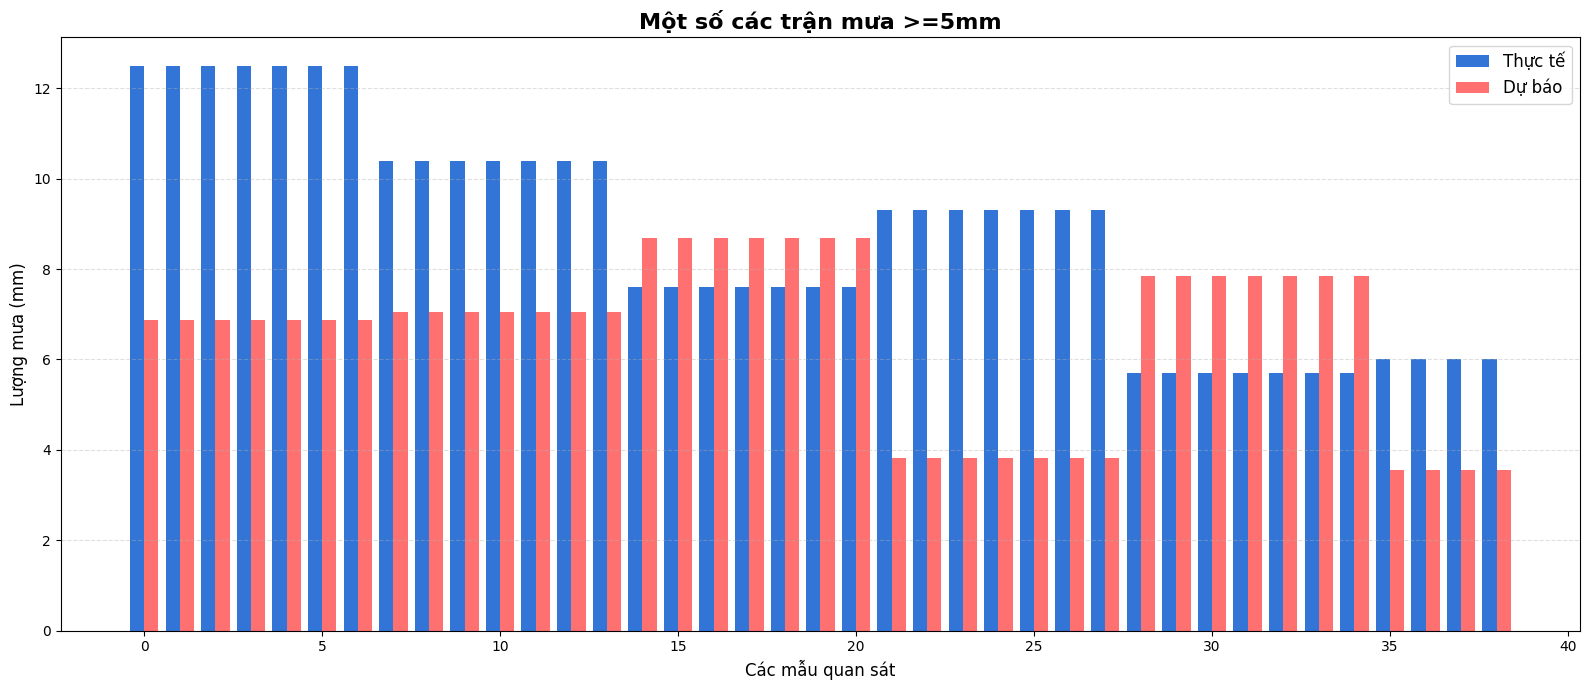

In [9]:
# minh hoạ kết quả dự báo vs thực tế
comparison = pd.DataFrame({'Thực tế': y_test, 'Dự báo': prediction})
subset = comparison[comparison['Thực tế'] > 5][21:60].copy()
subset = subset.reset_index(drop=True)

plt.figure(figsize=(16, 7))
indices = range(len(subset))

plt.bar([i - 0.2 for i in indices], subset['Thực tế'], 
        width=0.4, label='Thực tế', color='#0052cc', alpha=0.8)
plt.bar([i + 0.2 for i in indices], subset['Dự báo'], 
        width=0.4, label='Dự báo', color='#ff4d4d', alpha=0.8)

plt.title('Một số các trận mưa >=5mm', fontsize=16, fontweight='bold')
plt.xlabel('Các mẫu quan sát', fontsize=12)
plt.ylabel('Lượng mưa (mm)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Nhận xét:

Biểu đồ so sánh giữa giá trị thực tế và giá trị dự báo cho thấy mô hình hoạt động khá tốt trong việc dự đoán lượng mưa. Các thanh biểu diễn giá trị thực tế và dự báo có xu hướng tương đồng, đặc biệt trong các trường hợp lượng mưa lớn (>= 5mm). Tuy nhiên, vẫn có một số trường hợp giá trị dự báo chênh lệch so với thực tế, điều này có thể do các yếu tố ngoại cảnh hoặc dữ liệu huấn luyện chưa bao quát hết các trường hợp.

Nhìn chung, mô hình có tiềm năng ứng dụng trong việc dự đoán lượng mưa, nhưng cần cải thiện thêm để giảm thiểu sai số trong các trường hợp đặc biệt. 